# **Experiment 2: Noisy Linear Query**
**Query feature vector**: generated from noisy-linear-query-generator<br>
**Market value vector**: generated from market-value-generator 

## **Input**

In [7]:
#Import the package
import numpy as np
import math
from matplotlib import pyplot as plt
from sklearn.preprocessing import normalize
from numpy.random import beta
import time

## **Reader and Time-Discounting Function**

In [8]:
def Query_Feature_Vector_Reader(T, n): #read the query feature from the file
    global dir2
    X = np.zeros((T, n), float)
    fX = open("%s/X_T_%d_n_%d"%(dir2, T,n))
    for t in range(T):
        line = fX.readline()
        if not line:
            break
        linesp = line.split()
        for i in range(n):
            X[t, i] = float(linesp[i])
    fX.close()
    return X

def Market_Value_Reader(T, n): #read the market value vector from the file
    global dir2
    theta_Star = np.zeros((n, 1), float)
    fTheta = open("%s/theta_T_%d_n_%d"%(dir2, T,n))
    line = fTheta.readline()
    linesp = line.split()
    for i in range(n):
        theta_Star[i,0] = float(linesp[i])
    fTheta.close()
    return theta_Star

def Result_Reader(T, n, index, metric, td_type): #read the result from the file
    global dir1
    #Method_name = ['Pure', 'TS', 'D-TS', 'SWTS', 'D-UCB', 'Biased-UCB', 'Biased-TS', 'Biased-TS with Initilization']
    Method_name = ['Pure', 'SWTS', 'D-UCB', 'Biased-UCB', 'Biased-TS'] #MAB methods name
    result = np.zeros((T, 1), float)
    fresult = open("%s/%d_%s_T_%d_n_%d_%s_%s" % (dir1, index, metric, T, n, td_type, Method_name[index]))
    for i in range(T):
        result[i,0] = float(fresult.readline().split()[0])
    fresult.close()
    return result

def ProcessTime_Result_Reader(T, n, td_type): #read the process time result from the file
    global dir1
    #Method_name = ['Pure', 'TS', 'D-TS', 'SWTS', 'D-UCB', 'Biased-UCB', 'Biased-TS', 'Biased-TS with Initilization']
    Method_name = ['Pure', 'SWTS', 'D-UCB', 'Biased-UCB', 'Biased-TS'] #MAB methods name
    result = np.zeros((len(Method_name), 1), float)
    fresult = open("%s/ProcessTime_T_%d_n_%d_%s" % (dir1, T, n, td_type))
    for i in range(5):
        result[i,0] = float(fresult.readline().split()[0])
    fresult.close()
    return result

In [9]:
def Exp_TD_1(t): # Expotential time-discounting factor
    a = 1
    b = 0.99
    c = 0.1
    d = 0
    dt = a * np.power(b, (c * t + d) )
    return dt
def Exp_TD_2(t): # Expotential time-discounting factor
    a = 1
    b = 0.99
    c = 0.01
    d = 0
    dt = a * np.power(b, (c * t + d) )
    return dt
def Exp_TD_3(t): # Expotential time-discounting factor
    a = 1
    b = 0.99
    c = 0.001
    d = 0
    dt = a * np.power(b, (c * t + d) )
    return dt

def Linear_TD(t): # Linear time-discounting factor
    global T
    a = - 1 / T
    b = 1
    dt = a * t + b
    return dt

def No_TD(t): # No time-discounting factor
    return 1

## **Main function**

###  MAB Algorithms

In [10]:
## The MAB methods for time-discounting factor learning: Pure version, TS, D-TS, SWTS, D-UCB, Biased-UCB, Biased-TS(our), Biased-TS with  Initilization(our)
## Input of functions: the recent round: t, time-discounting rounds: exc, parameter updating signal: up, original price: pt_o, selected arm index: It
## Output of functions: selected arm index: It
'''
Pure Version
'''
def Pure(t, exc, up, pt_o, It):
    global K
    return K-1


'''
Sliding-window Thompson Sampling
'''
def SWTS(t, exc, up, pt_o, It):
    global K, d, ts_theta, na, nr, T
    tao = int(np.power(T, 0.5)) # tao = T^0.5 in [SWTS]
    ## Update the parameter\ up=-1: no update, up=1: positive update, up=0: negative
    if up == -1:
        if exc < K:
            #return (K-exc-1)
            return exc
        else:
            taot = np.min((t, tao))
            for i in range(K):
                ts_theta[i] = beta(sum(na[i, t-taot:t]) + 1, sum(nr[i, t-taot:t]) + 1, size = 1)
            It = np.argmax(ts_theta)
        return It
    #accept
    elif up == 1:
        na[It, t] = na[It, t] + 1 
    #reject
    else:
        nr[It, t] = nr[It, t] + 1
    return -1

'''
Discounted UCB
'''
def D_UCB(t, exc, up, pt_o, It):
    global K, d, uc, nc, wc, nc_bar, uc_bar, mc_bar
    lamda1 = 0.9 #lamda1 = 0.9: attenuation factor in [Mao]
    a =  2 #a = 400 in [Mao], 2 in [Auer]
    ## Update the parameter\ up=-1: no update, up=1: positive update, up=0: negative
    if up == -1:
        if exc < K:
            #return (K-exc-1)
            return exc
        ##探索与利用
        else:
            ##选择折扣值
            for i in range(K):
                #nc_bar[i, t-1] = sum(nc[i, s] for s in range(0, t)) #累计选择次数
                #mc_bar[i, t-1] = sum(pow(lamda1, t-s)*nc[i, s] for s in range(0, t)) #计算带权重的累计选择次数
                #uc_bar[i, t-1] = sum(pow(lamda1, t-s)*uc[i, s] for s in range(0, t)) / mc_bar[i, t-1] #求得加权平均收益
                wc[i, t-1] = uc_bar[i, t-1] + pow(a * np.log(t-1) / nc_bar[i, t-1], 0.5) #计算UCB
            It = np.argmax(wc[:, t-1])
        return It
    #accept
    elif up == 1:
        uc[It, t] = pt_o * d[It] 
        nc[It, t] = 1
    #reject
    elif up == 0:
        uc[It, t] = 0 
        nc[It, t] = 1
    else:
        for i in range(0, K):
            uc_sum[i, t] = lamda1 * (uc_sum[i, t-1] + uc[i, t])
            nc_bar[i, t] = nc_bar[i, t-1] + nc[i, t]
            mc_bar[i, t] = lamda1 * (mc_bar[i, t-1] + nc[i, t])
            if mc_bar[i, t] == 0:
                uc_bar[i, t] = 0
            else:
                uc_bar[i, t] = uc_sum[i, t] / mc_bar[i, t]
    return -1 

'''
Biased UCB
'''
def Biased_UCB(t, exc, up, pt_o, It):
    global K, d, uc, nc, wc, uc_sum, nc_bar, uc_bar, mc_bar
    lamda1 = 0.9 #lamda1 = 0.9: attenuation factor in [Mao]
    a =  2 #a = 400 in [Mao], 2 in [Auer]
    ## Update the parameter\ up=-1: no update, up=1: positive update, up=0: negative
    if up == -1:
        if exc < K:
            #return (K-exc-1)
            return exc
        else:
            for i in range(K):
                #nc_bar[i, t-1] = sum(nc[i, s] for s in range(0, t)) 
                #mc_bar[i, t-1] = sum(pow(lamda1, t-s)*nc[i, s] for s in range(0, t)) 
                #uc_bar[i, t-1] = sum(pow(lamda1, t-s)*uc[i, s] for s in range(0, t)) / mc_bar[i, t-1] 
                wc[i, t] = uc_bar[i, t-1] + pow(a * np.log(t-1) / nc_bar[i, t-1], 0.5) 
            It = np.argmax(wc[:, t])
        return It
    #accept
    elif up == 1:
        for i in range(0, It+1): 
            uc[i, t] = pt_o * d[i] 
            nc[i, t] = 1
    #reject
    elif up == 0:
        for i in range(It, K): 
            uc[i, t] = 0 
            nc[i, t] = 1
    else:
        for i in range(0, K):
            uc_sum[i, t] = lamda1 * (uc_sum[i, t-1] + uc[i, t])
            nc_bar[i, t] = nc_bar[i, t-1] + nc[i, t]
            mc_bar[i, t] = lamda1 * (mc_bar[i, t-1] + nc[i, t])
            if mc_bar[i, t] == 0:
                uc_bar[i, t] = 0
            else:
                uc_bar[i, t] = uc_sum[i, t] / mc_bar[i, t]
    return -1 

'''
Biased Thompson Sampling
'''
def Biased_TS(t, exc, up, pt_o, It):
    global K, d, ts_alpha, ts_beta, ts_theta, ts_w, ts_p, TD_name
    gamma = 0.8
    lamda1 = 1.6 #1.9
    ## Update the parameter\ up=-1: no update, up=1: positive update, up=0: negative
    if up == -1:
        if exc < K:
            #eturn (K-exc-1)
            return exc
        for i in range(K):
            ts_p[i] = ts_w[i] / sum(ts_w)
            ts_theta[i] = (1 - gamma) * ts_p[i] + gamma * beta(ts_alpha[i], ts_beta[i], size = 1) 
        It = np.argmax(ts_theta)
        return It
    #accept
    elif up == 1:
        for i in range(0, It+1): 
            ts_alpha[i] = ts_alpha[i]+ (lamda1)**i 
        ts_w[It] = ts_w[It] + 1
    #reject
    else:
        for i in range(It, K): 
            ts_beta[i] = ts_beta[i] + (lamda1)**i
    return -1


### Pricing process

In [11]:
def Ellipsoid_Pricing_with_Time_Discounting(MAB_method, TD_type):  
    '''
    Global/inital variables  
    
    PART1: Parameters  
        T: total pricing rounds
        n: dimension of feature vector
        R2: the square value of the original ellipsoid's radius
        S: the norm of xt
        delta: upper bound of value noise
        epsilon1: threshold of ellipsoid's width for choosing the exploit/explore price
        epsilon2: threshold of MAB method for choosing the time-dicounting value
        gamma: EE-balance factor of Biased-TS
        lamda1: hyperparameter of MAB methods
        a: EE-balance factor of Biased-UCB and D-UCB
        tao: window size of SWTS
        theta_star: market value vector
        X: query feature vector set
        K: number of bandit arms
        d: bandit arms / candidates of time-discounting
    
    PART2: Variables of algorithms
        A: shape matrix of ellipsoid
        c: center of ellipsoid
        ts_beta: beta para of BETA distribution
        ts_alpha: alpha para of BETA distribution
        ts_w: weight of arms in Biased-TS
        ts_p: weight ratio of arms in Biased-TS
        uc: reward of each round of each arm in UCB-method
        nc: selected signal of each round of each arm in UCB-method
        wc: ucb value in UCB-method
        nc_bar: cumulative selected times in UCB-method
        uc_sum: cumulative reward
        uc_bar: cumulative reward / discounted cumulative selected tims in UCB-method
        mc_bar: average reward in UCB-method
        na: number of accept in SWTS
        nr: number of reject in SWTS
    
    PART3: Recording variables
        regretVec: regret of each round
        totaltegretVec: cumulative regret
        totalMarketValue: cumulative market value
        regretRatio: regret ratio
        revenue: revenue of each round
        totalrevenue: cumulative revenue
        mvt: market value of each round
        ptt: posted price of each round
        ptl: price lower bound of each round
        ptu: price upper bound of each round
        within_count: judge whether theta* is in the current ellipsoid
        discount_count: times of learning time-discounting
        discount_flag: signal/flag of learning time-discounting  
        arm: selected arm in each round
    '''
    global T,n,R2,S,delta,epsilon1,epsilon2,gamma,lamda1,a,tao,theta_star,X,K,d
    global A,c,ts_alpha,ts_beta,ts_theta,ts_w,ts_p,uc,nc,wc,nc_bar,uc_sum,uc_bar,mc_bar,na,nr
    global regretVec,totalregretVec,totalMarketValue,regretRatio,revenue,totalrevenue,mvt,ptt,ptl,ptu,within_count,discount_count,discount_flag,arm

    '''
    Pricing process
    '''
    for t in range(T):

        xt = np.zeros((n,1), float)
        xt[:,0] = X[t]
        xt_T = xt.transpose()

        #the market value with time-discounting factor
        vt = np.dot(xt_T, theta_star) * TD_type(t)

        #intermediate vector
        bt = np.dot(A, xt)/(1.0 * math.sqrt(np.dot(np.dot(xt_T, A), xt)))
        bt_T = bt.transpose()
        
        #time-discounting learning flag
        discount_flag = 0
        
        #the chosen arm's index, original price without time-discounting, price, lower bound and upper bound  
        It = -1
        pt_o = 0.0
        pt = 0.0
        pt_lower = np.dot(xt_T, c - bt)
        pt_upper = np.dot(xt_T, c + bt)

        if(0 > pt_upper):
            if (t == 0):
                totalregretVec[t] = regretVec[t]
                totalMarketValue[t] = vt
            else:
                totalregretVec[t] = totalregretVec[t - 1] + regretVec[t]
                totalMarketValue[t] = totalMarketValue[t - 1] + vt
            continue
        else:
            #exploratory price
            if((pt_upper - pt_lower) > epsilon1):
                pt = max(0, (pt_lower + pt_upper)/2)
                exploit_flag = 0          
            #conservative price
            else:
                pt = max(0, pt_lower)
                exploit_flag = 1
            
            #learning the time-discounting factor
            if (t/T > epsilon2):
                It = MAB_method(t, discount_count, -1, pt_o, It)
                arm[t] = It
                dt = d[It]
                pt_o = pt
                pt = pt * dt
                discount_count = discount_count + 1
                discount_flag = 1
            
            #explore price
            if exploit_flag == 0:
                #handle feedback from the data consumer
                #posted price is rejected
                if(pt > vt):
                    #position parameter
                    alphat = ((pt_lower + pt_upper)/2.0 - pt)/(math.sqrt(np.dot(np.dot(xt_T,A),xt)))
                    #update the shape matrix and center of ellipsoid
                    if((alphat >= (-1.0/n)) and (alphat <= 1)):
                        nextA =(n**2 * (1 - alphat**2) * 1.0 /(n**2 - 1)) * (A - (2.0 * (1 + n * alphat)/((n + 1) * (1 + alphat))) * np.dot(bt,bt_T))
                        nextc = c - ((1 + n * alphat) * 1.0 /(n + 1)) * bt
                        A = nextA
                        c = nextc
                    #update the parameters of MAB methods
                    if discount_flag == 1:
                        MAB_method(t, discount_count, 0, pt_o, It)
                    if MAB_method == Biased_UCB or MAB_method == D_UCB:
                        MAB_method(t, discount_count, 2, pt_o, It)

                    #record regret
                    if ((vt > 0) and (pt - vt > 0.0001)):
                        regretVec[t] = vt
                        revenue[t] = 0
                        
                # posted price is accepted
                else:
                    # position parameter
                    alphat = ((pt_lower + pt_upper) / 2.0 - pt) / (math.sqrt(np.dot(np.dot(xt_T, A), xt)))
                    alphat_neg = alphat * -1
                    if((alphat_neg >= (-1.0 /n)) and (alphat_neg <= 1)):
                        nextA = (n**2 * (1 - alphat**2) * 1.0 /(n**2 - 1)) * (A - (2.0 * (1 - n * alphat)/((n+1) * (1 - alphat))) * (np.dot(bt, bt_T)))
                        nextc = c + ((1 - n * alphat) * 1.0 /(n + 1)) * bt
                        A = nextA
                        c = nextc
                    #update the parameters of MAB methods
                    if discount_flag == 1:
                        MAB_method(t, discount_count, 1, pt_o, It)
                    if MAB_method ==  Biased_UCB or MAB_method == D_UCB:
                        MAB_method(t, discount_count, 2, pt_o, It)

                    #record regret
                    regretVec[t] = vt - pt
                    revenue[t] = pt
            #exploit price
            else:
                #handle feedback from the data consumer
                #posted price is rejected
                if(pt > vt):
                    if discount_flag == 1:
                        MAB_method(t, discount_count, 0, pt_o, It)
                    if MAB_method ==  Biased_UCB or MAB_method == D_UCB:
                        MAB_method(t, discount_count, 2, pt_o, It)
                    #record regret
                    if ((vt > 0) and (pt - vt > 0.0001)):#pt - vt) > 10**(-1)
                        regretVec[t] = vt
                        revenue[t] = 0
                        
                #posted price is accepted
                else:
                    if discount_flag == 1:
                        MAB_method(t, discount_count, 1, pt_o, It) 
                    if MAB_method ==  Biased_UCB or MAB_method == D_UCB:
                        MAB_method(t, discount_count, 2, pt_o, It)
                    #record regret
                    regretVec[t] = vt - pt
                    revenue[t] = pt
        """
        Regret
        """
        if (t == 0):
            totalregretVec[t] = regretVec[t]
            totalMarketValue[t] = vt
            totalrevenue[t] = revenue[t]
        else:
            totalregretVec[t] = totalregretVec[t - 1] + regretVec[t]
            totalMarketValue[t] = totalMarketValue[t - 1] + vt
            totalrevenue[t] = totalrevenue[t-1] + revenue[t]
        mvt[t] = vt
        ptt[t] = pt
        ptl[t] = pt_lower
        ptu[t] = pt_upper
    """
    Regret Ratio
    """
    #calculate the regret ratio
    for t in range(T):
        if(totalMarketValue[t] != 0):
            regretRatio[t] = totalregretVec[t] * 1.0 / totalMarketValue[t]
    
    return regretVec, regretRatio, totalregretVec, ptt, mvt, totalrevenue, arm

### Run the process

In [12]:
if __name__=='__main__':
    dir1 = './Ex2_NoisyLinearQuery/output2' 
    dir2 = './Ex2_NoisyLinearQuery/input'
    '''
    Method List
    '''
    Method_list = [Pure, SWTS, D_UCB, Biased_UCB, Biased_TS] #MAB methods list
    Method_name = ['Pure', 'SWTS', 'D-UCB', 'Biased-UCB', 'Biased-TS'] #MAB methods name
    '''
    Time-discounting factor
    '''
    #TD_type_list = [Exp_TD, Linear_TD, No_TD] #time-discounting type list
    TD_type_name = ['Exp', 'Linear', 'No'] #the name of time-discounting type
    '''
    Run
    '''
    #for (n, T, TD_type) in [(5, 1000, Exp_TD_1), (20, 10000, Exp_TD_2), (40, 10000, Exp_TD_2), (60, 100000, Exp_TD_3), (80, 100000, Exp_TD_3), (100, 100000, Exp_TD_3)]:
    for (n, T, TD_type) in [(20, 10000, Linear_TD)]:
        TD_name = 'Linear'
        #for TD_type in TD_type_list:
            #TD_name = TD_type_name[TD_type_list.index(TD_type)] #the name of chosen time-discounting type
        '''
        Loop
        '''
        lc = 100 #loop count
        ProcessTime_ave = np.zeros(len(Method_list), float) #running time
        
        for index, method in enumerate(Method_list):
            ## Parameters of rounds and vectors
            #T = 5000 #number of rounds
            #n = 10 #dimension of features
            R2 = 4 * n #2-norm domain of weight vector
            S = 1 #2-norm domain of feature vector
            '''
            Recording variables
            '''
            regretVec_ave = np.zeros(T, float) #regret
            totalregretVec_ave = np.zeros(T, float) #cumulative regret
            regretRatio_ave = np.zeros(T, float) #regret ratio
            mvt_ave = np.zeros(T, float) #market value
            ptt_ave = np.zeros(T, float) #posted price
            totalrevenue_ave = np.zeros(T, float) #cumulative revenue
            arm_ave = np.zeros(T, float) #selected arm
            
            for i in range(lc):
                '''
                Global/inital variables        
                '''
                ## Shape matrix and center of the ellipsoid
                A = np.identity(n)
                for i in range(n):
                    A[i, i] = R2
                c = np.zeros((n,1),float)
                
                ## Threshold
                epsilon1 = (n**2) * 1.0 /T #threshold of EP
                epsilon2 = 0.01 #threshold of MAB

                ## Parameters of MAB
                if T <= 10000:
                    K = 50 #bandit arm number
                else:
                    K = 70
                d = np.linspace(0, 1, K) #bandit arm
                ts_alpha = np.ones(K, float) #alpha of TS
                ts_beta = np.ones(K, float) #beta of TS
                ts_theta = np.zeros(K, float) #sampling value theta
                ts_w = np.ones(K, float) #weight of arms
                ts_p = np.ones(K, float) #weight percentage of arms
                # parameter of UCB methods
                uc = np.zeros((K, T)) #historical single reward
                nc = np.zeros((K, T)) #record of selected number
                wc = np.zeros((K, T)) #record of weight
                nc_bar = np.zeros((K, T)) #record of cumulative selected numbers
                uc_sum = np.zeros((K, T)) #record of cumulative reward 
                uc_bar = np.zeros((K, T)) #record of cumulative reward / cumulative selected numbers
                mc_bar = np.zeros((K, T)) #record of average reward
                # parameter of SWTS
                na = np.zeros((K, T)) #record of selected arms with accepted price
                nr = np.zeros((K, T)) #record of selected arms with rejected price
                
                '''
                Counting/recording variables of metrics    
                '''
                regretVec = np.zeros(T, float) #regret of single round
                totalregretVec = np.zeros(T, float) #cumulative regret
                totalMarketValue = np.zeros(T, float) #cumulative market value
                regretRatio = np.zeros(T, float) #regret ratio
                revenue = np.zeros(T, float) #revenue of single round
                totalrevenue = np.zeros(T, float) #total revenue
                arm = np.zeros(T, float)

                mvt = np.zeros(T, float) #market value
                ptt = np.zeros(T, float) #posted price
                ptl = np.zeros(T, float) #lower bound
                ptu = np.zeros(T, float) #upper bound

                within_count = np.zeros(T, float) #judgement of whether the price is in the ellipsoid
                discount_count = 0 #record of time-discounting factor learning rounds
                discount_flag = 0 #flag of time-discounting learning
                
                '''
                Market value vector and feature vectors
                '''
                theta_star = Market_Value_Reader(T, n)
                X = Query_Feature_Vector_Reader(T, n)
                
                '''
                Pricing process
                '''
                start_time = time.time()
                regretVec_temp, regretRatio_temp, totalregretVec_temp, ptt_temp, mvt_temp, totalrevenue_temp, arm_temp = Ellipsoid_Pricing_with_Time_Discounting(method, TD_type)
                end_time = time.time()
                
                '''
                Recording
                '''
                # record the sum of metics value
                regretVec_ave = regretVec_ave + regretVec_temp
                regretRatio_ave = regretRatio_ave + regretRatio_temp
                totalregretVec_ave = totalregretVec_ave + totalregretVec_temp
                ptt_ave = ptt_ave + ptt_temp
                mvt_ave = mvt_ave + mvt_temp
                totalrevenue_ave = totalrevenue_ave + totalrevenue_temp
                arm_ave = arm_ave + arm_temp
                ProcessTime_ave[index] = ProcessTime_ave[index] + (end_time - start_time)
                
            # calculate the average metrics value
            regretVec_ave = regretVec_ave / lc
            regretRatio_ave = regretRatio_ave / lc
            totalregretVec_ave = totalregretVec_ave / lc
            ptt_ave = ptt_ave / lc
            mvt_ave = mvt_ave / lc
            totalrevenue_ave = totalrevenue_ave / lc
            arm_ave = arm_ave / lc
            ProcessTime_ave[index] = ProcessTime_ave[index] / lc
            # save the results
            np.savetxt("%s/%d_RegretVec_T_%d_n_%d_%s_%s" % (dir1, index, T, n, TD_name, Method_name[index]), regretVec_ave, fmt='%.10f')
            np.savetxt("%s/%d_TotalRegret_T_%d_n_%d_%s_%s" % (dir1, index, T, n, TD_name, Method_name[index]), totalregretVec_ave, fmt='%.10f')
            np.savetxt("%s/%d_RegretRatio_T_%d_n_%d_%s_%s" % (dir1,index, T, n, TD_name, Method_name[index]), regretRatio_ave, fmt='%.10f')
            np.savetxt("%s/%d_MarketValue_T_%d_n_%d_%s_%s" % (dir1,index, T, n, TD_name, Method_name[index]), mvt_ave, fmt='%.10f')
            np.savetxt("%s/%d_PostedPrice_T_%d_n_%d_%s_%s" % (dir1,index, T, n, TD_name, Method_name[index]), ptt_ave, fmt='%.10f')
            np.savetxt("%s/%d_SelectedArm_T_%d_n_%d_%s_%s" % (dir1,index, T, n, TD_name, Method_name[index]), arm_ave, fmt='%.10f')
            np.savetxt("%s/%d_TotalRevenue_T_%d_n_%d_%s_%s" % (dir1,index, T, n, TD_name, Method_name[index]), totalrevenue_ave, fmt='%.10f')
        np.savetxt("%s/ProcessTime_T_%d_n_%d_%s" % (dir1, T, n, TD_name), ProcessTime_ave, fmt='%.10f')

## **Result**

### Draw the results

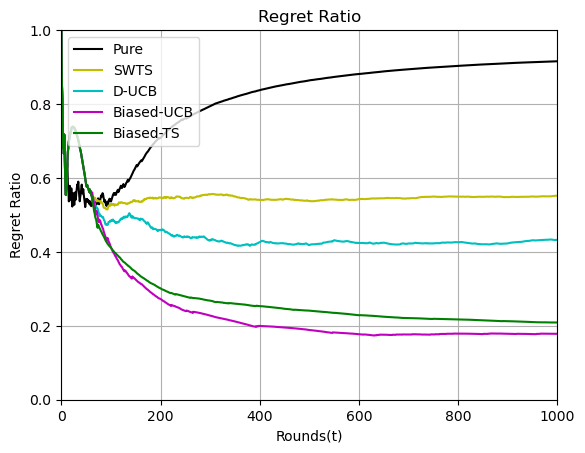

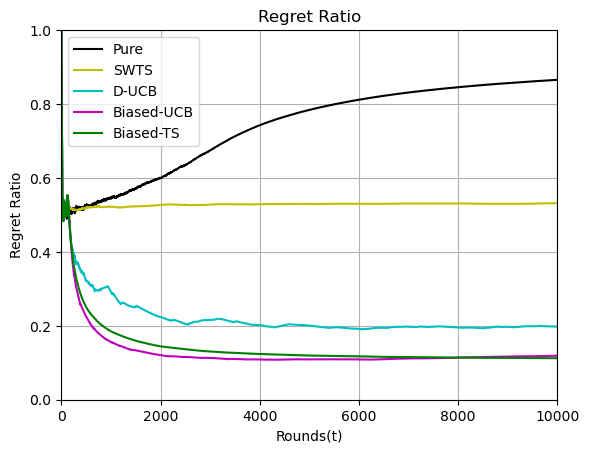

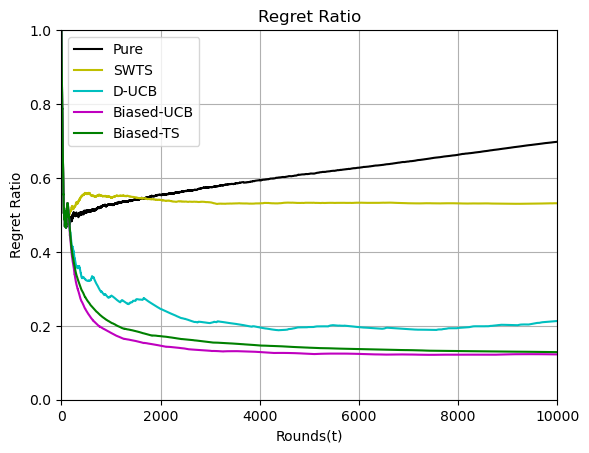

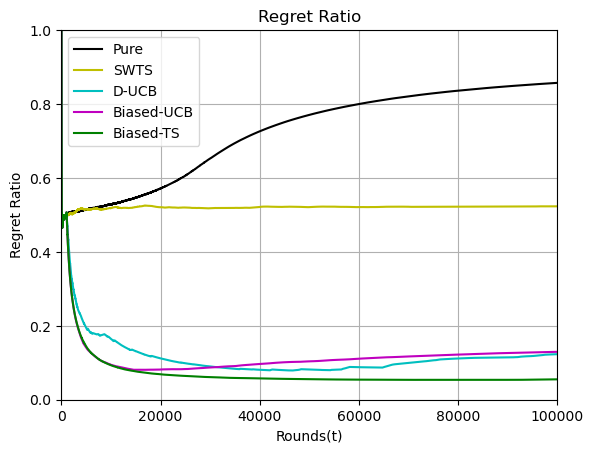

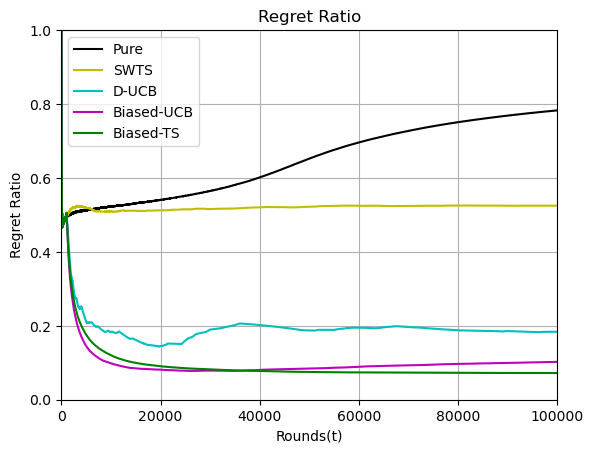

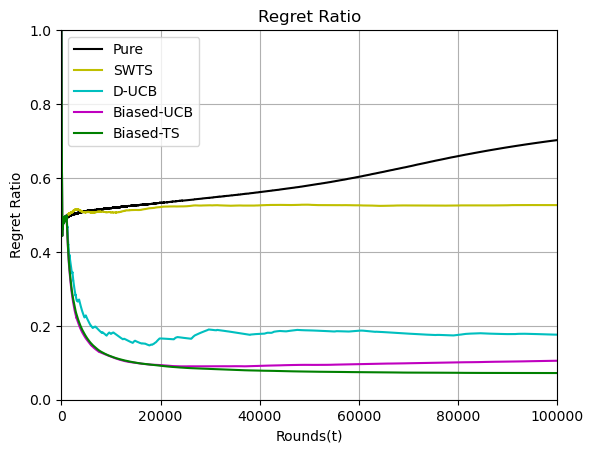

In [13]:
#T = 5000
#n = 10
dir1 = './Ex2_NoisyLinearQuery/output2' 
dir2 = './Ex2_NoisyLinearQuery/input'
'''
Read the results
'''
#Method_name = ['Pure', 'TS', 'D-TS', 'SWTS', 'D-UCB', 'Biased-UCB', 'Biased-TS', 'Biased-TS with Initilization']
Metrics = ['RegretVec', 'TotalRegret', 'RegretRatio', 'MarketValue', 'PostedPrice', 'ProcessTime', 'TotalRevenue', 'SelectedArm']
Method_list = [Pure, SWTS, D_UCB, Biased_UCB, Biased_TS] #MAB methods list
Method_name = ['Pure', 'SWTS', 'D-UCB', 'Biased-UCB', 'Biased-TS'] #MAB methods name
td_type = 'Linear' #TD_name #'Exp', 'Linear', 'No'

for index, (n, T) in enumerate([(20, 10000)]):
#for index, (n, T) in enumerate([(5, 1000), (20, 10000), (40, 10000), (60, 100000), (80, 100000), (100, 100000)]):
    TotalRegret = np.zeros((T, len(Method_name)), float)
    RegretRatio = np.zeros((T, len(Method_name)), float)
    TotalRevenue = np.zeros((T, len(Method_name)), float)
    ProcessTime = np.zeros((1, len(Method_name)), float)
    #MarketValue = np.zeros(T, float)
    #PostedPrice = np.zeros(T, float)
    for i in range(len(Method_name)):
        TotalRegret[:,i] = Result_Reader(T, n, i, Metrics[1], td_type)[:,0]
        RegretRatio[:,i] = Result_Reader(T, n, i, Metrics[2], td_type)[:,0]
        TotalRevenue[:,i] = Result_Reader(T, n, i, Metrics[6], td_type)[:,0]
    #MarketValue = Result_Reader(T, n, 4, Metrics[3], td_type)[:,0]
    #PostedPrice = Result_Reader(T, n, 4, Metrics[4], td_type)[:,0]
    ProcessTime = ProcessTime_Result_Reader(T, n, td_type)

    np.savetxt("%s/RegretRatio_T_%d_n_%d_%s" % (dir1, T, n, TD_name), RegretRatio, fmt='%.10f')
    np.savetxt("%s/TotalRevenue_T_%d_n_%d_%s" % (dir1, T, n, TD_name), TotalRevenue, fmt='%.10f')
    np.savetxt("%s/ProcessTime_T_%d_n_%d_%s" % (dir1, T, n, TD_name), ProcessTime, fmt='%.10f')

    '''
    Draw the results
    '''
    color = ['k-', 'y-', 'c-', 'm-', 'g-', 'b-', 'r-', 'pink']
    tt = range(T)
    plt.figure(index+1)
    for i in range(len(Method_name)):
        plt.plot(tt, RegretRatio[:,i], color[i], label='%s' % Method_name[i])
        #plt.text(tt[T-1], RegretRatio[T-1, i], "%0.1f" % RegretRatio[T-1,i])
    plt.title('Regret Ratio')
    plt.xlabel('Rounds(t)')
    plt.ylabel('Regret Ratio')
    plt.xlim(0, T)
    plt.ylim(0, 1)
    plt.grid()
    plt.legend()
